In [ ]:
%matplotlib inline

import os
from cycler import cycler
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [ ]:
def get_stats_from_file(filename):
    with open(filename, 'r') as file:
        header = file.readline().split()
        stats_lists = [[cat] for cat in header]
        for line in file:
            for i,stat in enumerate(line.strip().split()):
                if i is 0: stat = datetime.fromtimestamp(float(stat)).strftime('%H:%M:%S.%f')[:-4]

                elif i is 1: stat = float(stat)
                else: stat = int(stat)
                stats_lists[i].append(stat)
                
        file_stats = {list[0]: list[1:] for list in stats_lists}
        return file_stats

In [ ]:
def hide_nth_xtick(ax, n):
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

In [123]:
def plot_stats(stats, node_names):
    params = {
       'axes.labelsize': 14,
       'font.size': 15,
       'legend.fontsize': 11,
       'legend.handlelength': 2,
       'xtick.labelsize': 12,
       'ytick.labelsize': 12,
       'text.usetex': False,
       'figure.figsize': [20, 20],
       'axes.prop_cycle': cycler('color', ['b', 'g', 'r', 'c', 'm', 'y', 'k']) +
                           cycler('linestyle', ['-', '--', ':', '-.', '-', '--', ':'])
    }
    plt.rcParams.update(params)
    
    fig = plt.figure()

    cpu = fig.add_subplot(511)
    mem = fig.add_subplot(512)
    failed = fig.add_subplot(513)
    received = fig.add_subplot(514)
    sent = fig.add_subplot(515)
    
    for node in node_names:
        cur_node = stats.get(node)
        cpu.set_ylabel('CPU usage')
        cpu.set_title('Percentage of CPU usage')

        mem.set_ylabel('Memory (in bytes)')
        mem.set_title('Active Memory usage')

        failed.set_ylabel('Puzzles')
        failed.set_title('Number of Puzzles Failed')

        received.set_ylabel('Puzzles')
        received.set_title('Number of Puzzles Received')

        sent.set_ylabel('Puzzles')
        sent.set_title('Number of Puzzles Sent')

        cpu.plot(cur_node['Timestamp'], cur_node['cpu_percent'],label=node,marker='s')
        mem.plot(cur_node['Timestamp'], cur_node['active_memory'],label=node,marker='s')
        failed.plot(cur_node['Timestamp'], cur_node['ChallengeFailed'],label=node,marker='s')
        received.plot(cur_node['Timestamp'], cur_node['ChallengeRecvd'],label=node,marker='s')
        sent.plot(cur_node['Timestamp'], cur_node['ChallengeSent'],label=node, marker='s')

    for plot in [cpu, mem, failed, received, sent]:
        plot.set_xlabel('Time')
        hide_nth_xtick(plot, 6)
        legend = plot.legend(loc = 9, ncol=10, bbox_to_anchor=(.5, -0.2), borderaxespad=1.0)
    
    fig.tight_layout(pad=1, h_pad=1)
    plt.show()

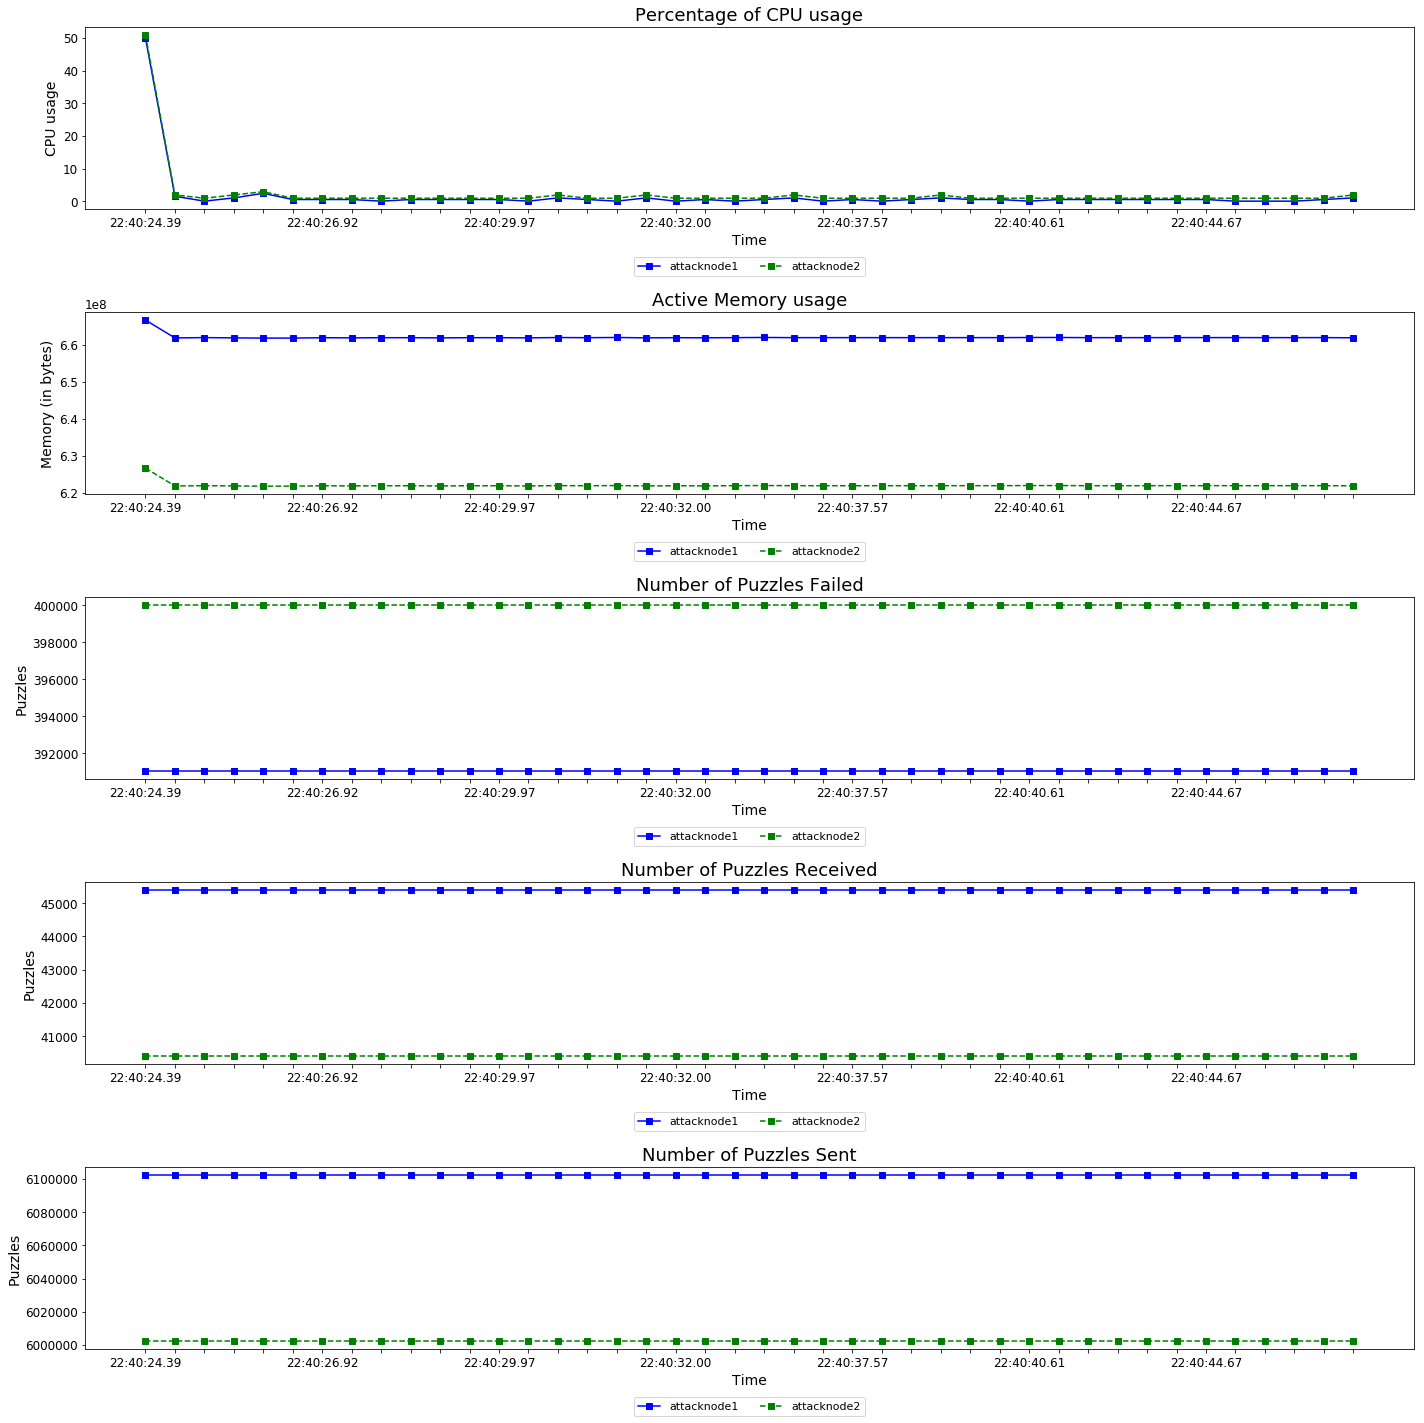

In [124]:
stats = {}
for filename in os.listdir('argusout'):
    stats[filename.strip('.out')] = get_stats_from_file('argusout/' + filename)

plot_stats(stats, [file.strip('.out') for file in os.listdir('argusout')])